### Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score


### Load the dataset and split in into train/test (IMPORTANT: NOT THE FINAL TEST)

In [2]:
df = pd.read_csv("topic-analysis-dataset.csv")
df.head()
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['topic'], test_size=0.2, random_state=42
)


### Text Vectorization using TF-IDF

In [3]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


### Train the SVM Classifier

In [4]:
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)


LinearSVC()

### Make Predictions and Evaluate the Model (IMPORTANT: NOT THE FINAL TEST)

In [5]:
y_pred = svm.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

Accuracy: 0.9882
Classification Report:
              precision    recall  f1-score   support

        book       0.97      0.99      0.98      9930
       movie       1.00      1.00      1.00      9987
      sports       0.99      0.97      0.98     10083

    accuracy                           0.99     30000
   macro avg       0.99      0.99      0.99     30000
weighted avg       0.99      0.99      0.99     30000



### Evaluate model on the final test dataset (IMPORTANT: FINAL TEST)

Classification Report:
              precision    recall  f1-score   support

        book       0.45      0.83      0.59         6
       movie       1.00      0.50      0.67         6
      sports       0.75      0.50      0.60         6

    accuracy                           0.61        18
   macro avg       0.73      0.61      0.62        18
weighted avg       0.73      0.61      0.62        18

Confusion Matrix:
[[5 0 1]
 [3 3 0]
 [3 0 3]]


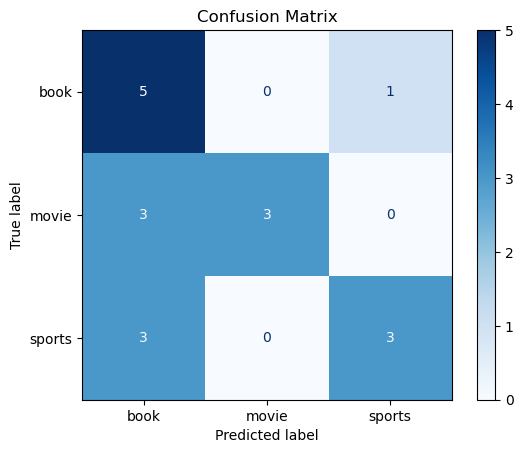


Detailed Results:
Sentence: The stadium was alive with the roar of the crowd after that incredible win.
True Label: sports
Predicted Label: sports
------------------------------------------------------------
Sentence: That last-minute goal had me jumping out of my seat—what an unbelievable finish!
True Label: sports
Predicted Label: book
------------------------------------------------------------
Sentence: I couldn’t put the book down; it swept me into a whole new world.
True Label: book
Predicted Label: sports
------------------------------------------------------------
Sentence: The story had its moments, though some parts felt like they dragged on a bit.
True Label: book
Predicted Label: book
------------------------------------------------------------
Sentence: I enjoyed the way the timelines shifted, even if it got a little confusing sometimes.
True Label: book
Predicted Label: book
------------------------------------------------------------
Sentence: Every time I watch this mo

In [7]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt  # <-- Add this import

# Load the data
df = pd.read_csv("../test-datasets/sentiment-topic-test.tsv", sep="\t")
sentences = df["sentence"].tolist()
true_labels = df["topic"].tolist()

# Transform the sentences using the TF-IDF vectorizer
X_test_tfidf = vectorizer.transform(sentences)

# Predict using the trained SVM model
predicted_labels = svm.predict(X_test_tfidf)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# Print confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

# Plot the confusion matrix in blue
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Print each sentence with its true and predicted label
print("\nDetailed Results:")
for sentence, true, pred in zip(sentences, true_labels, predicted_labels):
    print(f"Sentence: {sentence}\nTrue Label: {true}\nPredicted Label: {pred}\n{'-'*60}")
